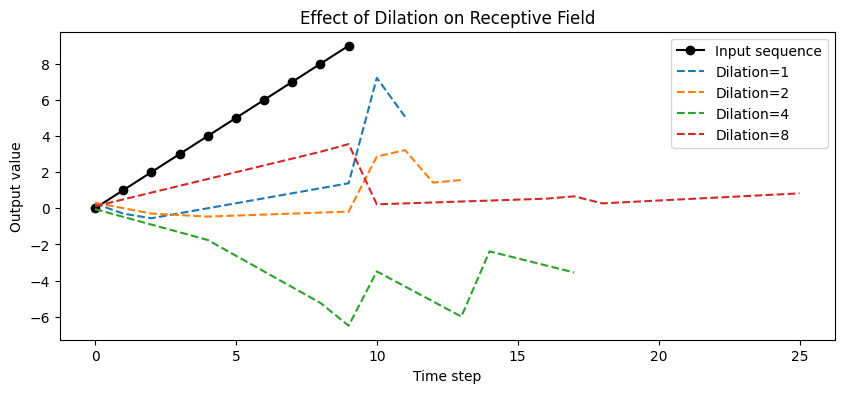

In [4]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# 샘플 입력 시퀀스
x = torch.arange(0, 10).float().view(1, 1, -1)  # (B=1, C=1, T=10)

# dilation 변화
dilations = [1, 2, 4, 8]
outputs = []

for d in dilations:
    conv = nn.Conv1d(1, 1, kernel_size=3, dilation=d, padding=(3-1)*d)
    y = conv(x)
    outputs.append(y.detach().numpy().flatten())

# 시각화
plt.figure(figsize=(10,4))
plt.plot(x.flatten(), 'ko-', label='Input sequence')
for i, d in enumerate(dilations):
    plt.plot(outputs[i], '--', label=f'Dilation={d}')
plt.legend(); plt.title("Effect of Dilation on Receptive Field")
plt.xlabel("Time step"); plt.ylabel("Output value")
plt.show()


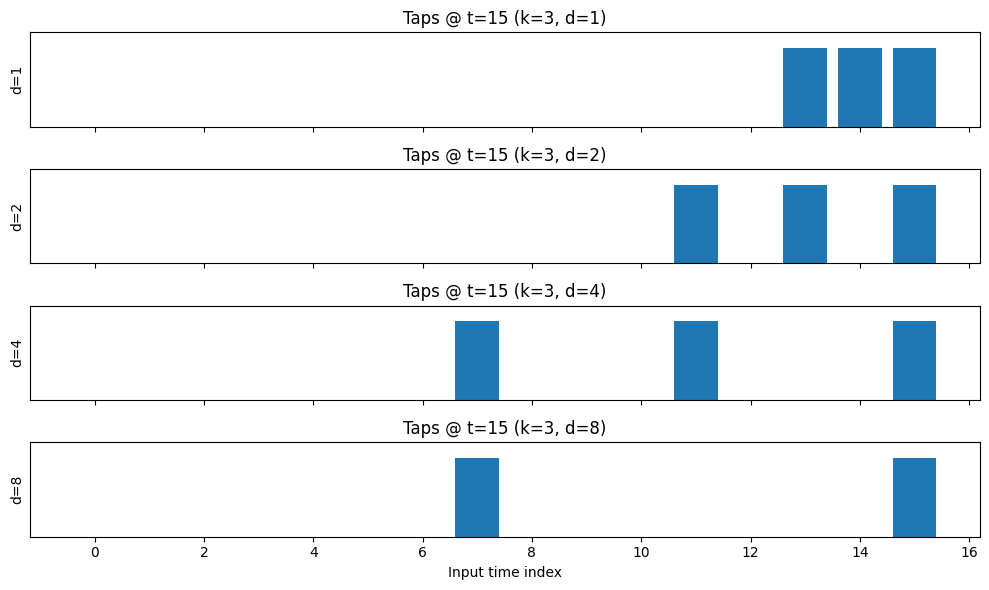

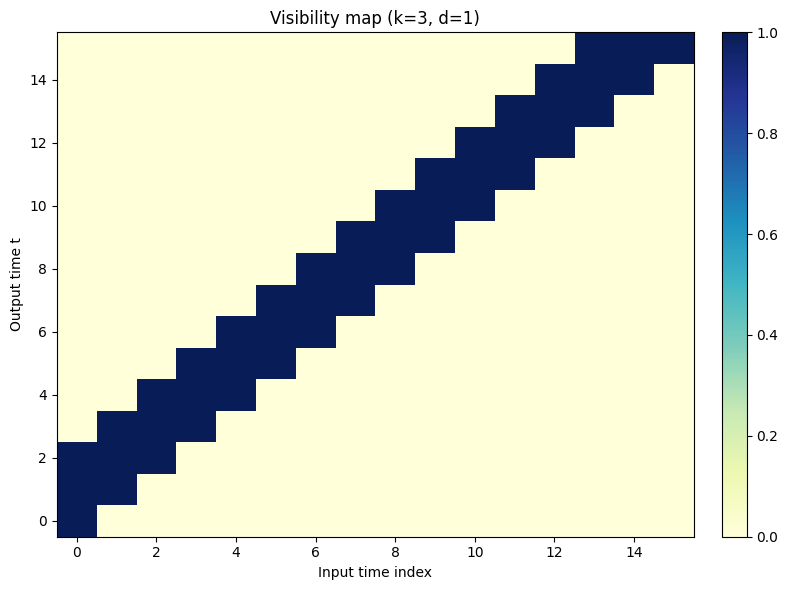

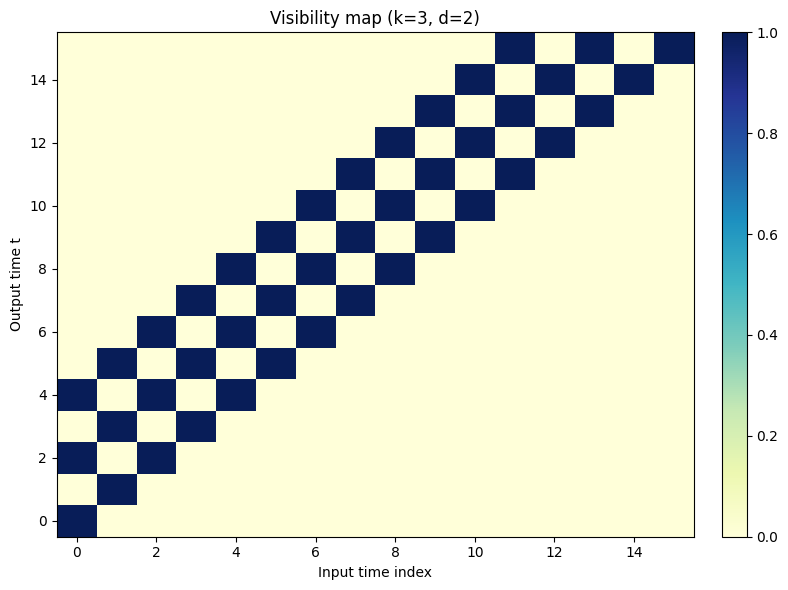

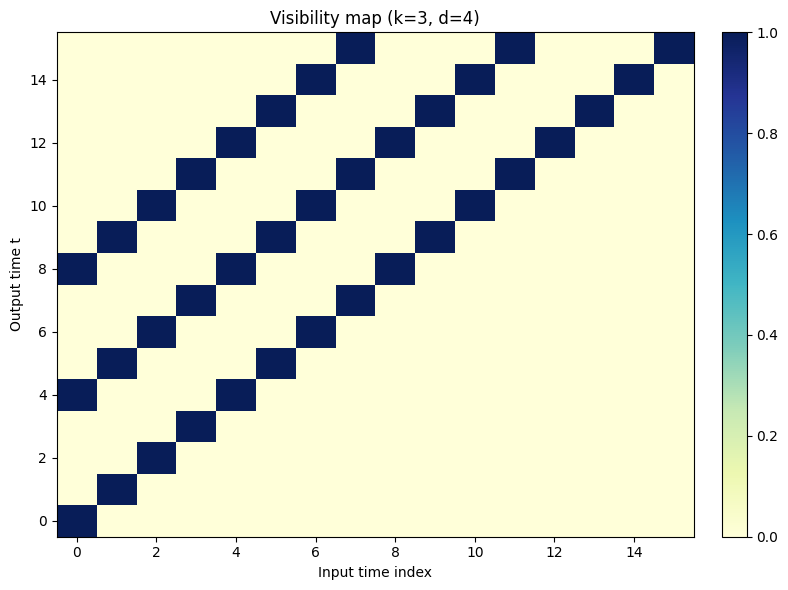

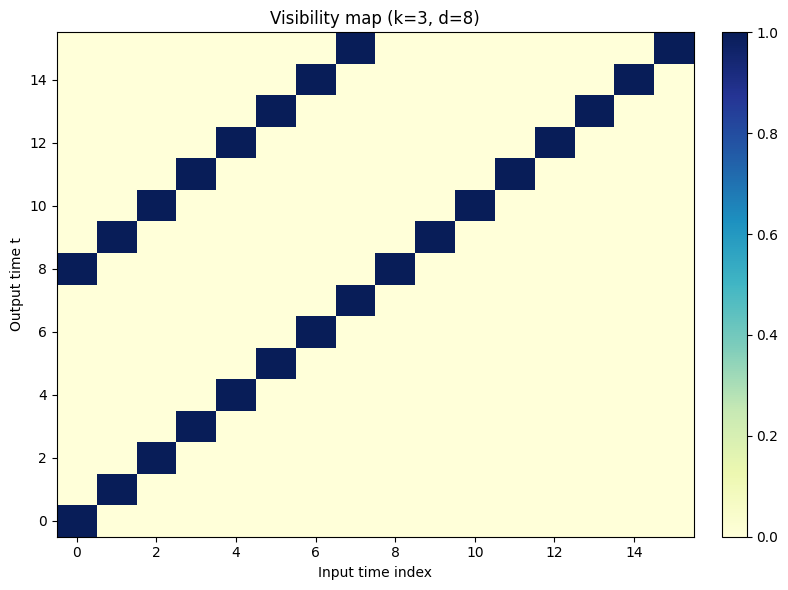

Receptive field sizes for each dilation: [3, 5, 9, 17]


In [8]:
import numpy as np
import matplotlib.pyplot as plt

def show_dilation_receptive_field(T=16, kernel=3, dilations=(1,2,4,8), t_focus=None):
    t_focus = T-1 if t_focus is None else t_focus
    
    def taps_for(t, d, k, Tlen):
        idx = [t - i*d for i in range(k)]
        return [i for i in idx if 0 <= i < Tlen]
    
    # 1) Tap barplots
    fig, axes = plt.subplots(len(dilations), 1, figsize=(10, 6), sharex=True)
    if len(dilations) == 1:
        axes = [axes]
    for ax, d in zip(axes, dilations):
        idxs = taps_for(t_focus, d, kernel, T)
        heights = np.zeros(T); heights[idxs] = 1.0
        ax.bar(np.arange(T), heights)
        ax.set_ylim(0, 1.2); ax.set_yticks([])
        ax.set_ylabel(f"d={d}")
        ax.set_title(f"Taps @ t={t_focus} (k={kernel}, d={d})")
    axes[-1].set_xlabel("Input time index")
    plt.tight_layout(); plt.show()
    
    # 2) Heatmaps (visibility map)
    for d in dilations:
        M = np.zeros((T, T))
        for t in range(T):
            idxs = taps_for(t, d, kernel, T)
            M[t, idxs] = 1.0
        fig, ax = plt.subplots(figsize=(8, 6))
        im = ax.imshow(M, aspect='auto', origin='lower', cmap="YlGnBu")
        ax.set_title(f"Visibility map (k={kernel}, d={d})")
        ax.set_xlabel("Input time index"); ax.set_ylabel("Output time t")
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        plt.tight_layout(); plt.show()
    
    # 3) Formula check
    rf_sizes = [(kernel-1)*d + 1 for d in dilations]
    print("Receptive field sizes for each dilation:", rf_sizes)

show_dilation_receptive_field(T=16, kernel=3, dilations=(1,2,4,8), t_focus=None)


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# =========================
# 1) UCI-HAR 로더
# =========================
SENSORS = [
    "body_acc_x", "body_acc_y", "body_acc_z",
    "body_gyro_x","body_gyro_y","body_gyro_z",
    "total_acc_x","total_acc_y","total_acc_z"
]
ACTIVITY_LABELS = ["WALKING","WALKING_UPSTAIRS","WALKING_DOWNSTAIRS","SITTING","STANDING","LAYING"]

class UCIHARDataset(Dataset):
    def __init__(self, data_path, split='train'):
        base = Path(data_path) / split
        signals = []
        for sensor in ['body_acc', 'body_gyro', 'total_acc']:
            for axis in ['x', 'y', 'z']:
                file = base / 'Inertial Signals' / f'{sensor}_{axis}_{split}.txt'
                signals.append(np.loadtxt(file))

        self.X = np.stack(signals, axis=-1)
        self.y = np.loadtxt(base.parent / split / f'y_{split}.txt').astype(int) - 1

        try:
            self.subjects = np.loadtxt(base.parent / split / f'subject_{split}.txt').astype(int)
        except:
            self.subjects = np.ones(len(self.y))

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return (torch.FloatTensor(self.X[idx]),
                torch.LongTensor([self.y[idx]])[0],
                self.subjects[idx])

# =========================
# 2) 모델들: TCN vs LSTM
# =========================
class TemporalBlock(nn.Module):
    def __init__(self, in_ch, out_ch, k=3, d=1, pdrop=0.1):
        super().__init__()
        pad = (k - 1) * d
        self.conv1 = nn.Conv1d(in_ch, out_ch, k, padding=pad, dilation=d)
        self.conv2 = nn.Conv1d(out_ch, out_ch, k, padding=pad, dilation=d)
        self.dropout = nn.Dropout(pdrop)
        self.relu = nn.ReLU()
        self.down = nn.Conv1d(in_ch, out_ch, 1) if in_ch != out_ch else None

    def forward(self, x):
        out = self.conv1(x); out = self.relu(out); out = self.dropout(out)
        out = self.conv2(out); out = self.relu(out); out = self.dropout(out)
        res = x if self.down is None else self.down(x)
        out = out[:, :, :res.size(2)]  # causal trim
        return self.relu(out + res)

class TCN(nn.Module):
    def __init__(self, in_ch=9, channels=(32,64,64), n_classes=6, kernel=3, pdrop=0.1):
        super().__init__()
        blocks = []
        for i, ch in enumerate(channels):
            dil = 2 ** i
            in_c = in_ch if i == 0 else channels[i-1]
            blocks.append(TemporalBlock(in_c, ch, k=kernel, d=dil, pdrop=pdrop))
        self.net = nn.Sequential(*blocks)
        self.fc = nn.Linear(channels[-1], n_classes)

    def forward(self, x):  # x:(B,C,T)
        x = x.transpose(1, 2)
        h = self.net(x)
        h = h.mean(dim=2)  # GAP
        return self.fc(h)

class LSTMHead(nn.Module):
    def __init__(self, in_ch=9, hidden=64, num_layers=1, bidir=False, n_classes=6, pdrop=0.1):
        super().__init__()
        self.rnn = nn.LSTM(input_size=in_ch, hidden_size=hidden, num_layers=num_layers,
                           batch_first=True, dropout=0.0 if num_layers==1 else pdrop,
                           bidirectional=bidir)
        mult = 2 if bidir else 1
        self.dropout = nn.Dropout(pdrop)
        self.fc = nn.Linear(hidden * mult, n_classes)

    def forward(self, x):  # x:(B,C,T) -> (B,T,C)
        out, _ = self.rnn(x)         # (B,T,H*mult)
        h = out[:, -1, :]            # last step
        h = self.dropout(h)
        return self.fc(h)

# =========================
# 3) 학습/평가 루프
# =========================
def train_one_epoch(model, loader, optimizer, scheduler, device):
    model.train()
    ce = nn.CrossEntropyLoss()
    losses = []
    y_true, y_pred = [], []
    for X, y, _ in loader:
        X, y = X.to(device), y.to(device)
        logits = model(X)
        loss = ce(logits, y)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        pred = logits.argmax(dim=1)
        y_true.extend(y.detach().cpu().numpy())
        y_pred .extend(pred.detach().cpu().numpy())
    if scheduler is not None:
        scheduler.step()
    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred, average='macro')
    return np.mean(losses), acc, f1

@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    ce = nn.CrossEntropyLoss()
    losses = []
    y_true, y_pred = [], []
    for X, y, _ in loader:
        X, y = X.to(device), y.to(device)
        logits = model(X)
        loss = ce(logits, y)
        losses.append(loss.item())
        pred = logits.argmax(dim=1)
        y_true.extend(y.detach().cpu().numpy())
        y_pred .extend(pred.detach().cpu().numpy())
    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred, average='macro')
    return np.mean(losses), acc, f1, np.array(y_true), np.array(y_pred)

def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# =========================
# 4) 메인: 공정 비교 실행
# =========================
def run_experiment(data_path, model_name="TCN", epochs=30, batch_size=64, lr=1e-3, wd=1e-4, device=None):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    print(f"[Device] {device}")

    train_ds = UCIHARDataset(data_path, split='train')
    test_ds = UCIHARDataset(data_path, split='test')

    # 논문 관례대로 train을 다시 (train/val)로 나누어 모니터링해도 좋지만
    # 여기선 깔끔히 train 성능/ test 성능만 보고 비교.
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False)
    test_loader  = DataLoader(test_ds , batch_size=batch_size, shuffle=False, drop_last=False)

    if model_name.upper() == "TCN":
        # 파라미터 수를 LSTM과 맞추려면 channels 조절
        model = TCN(in_ch=9, channels=(32,64,64), n_classes=6, kernel=3, pdrop=0.1)
    else:
        # LSTM hidden 조절로 파라미터를 TCN과 근접
        model = LSTMHead(in_ch=9, hidden=64, num_layers=1, bidir=False, n_classes=6, pdrop=0.1)

    model = model.to(device)
    n_params = count_params(model)
    print(f"[Model] {model_name} | params: {n_params/1e6:.4f} M")

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    best = {"f1": -1, "acc": -1, "state": None}
    for ep in range(1, epochs+1):
        tr_loss, tr_acc, tr_f1 = train_one_epoch(model, train_loader, optimizer, scheduler, device)
        te_loss, te_acc, te_f1, y_true, y_pred = evaluate(model, test_loader, device)
        if te_f1 > best["f1"]:
            best = {"f1": te_f1, "acc": te_acc, "state": {k:v.detach().cpu() for k,v in model.state_dict().items()}}
        print(f"[{model_name}] Ep {ep:02d}/{epochs} | Train Acc={tr_acc:.4f} F1={tr_f1:.4f} | Test Acc={te_acc:.4f} F1={te_f1:.4f}")

    # 최종/최고 성능 리포트
    model.load_state_dict(best["state"])
    _, te_acc, te_f1, y_true, y_pred = evaluate(model, test_loader, device)
    print("="*80)
    print(f"[{model_name}] BEST Test Acc={te_acc:.4f} | F1={te_f1:.4f}")
    print(classification_report(y_true, y_pred, target_names=ACTIVITY_LABELS, digits=4))
    print("Confusion Matrix (row-normalized):")
    cm = confusion_matrix(y_true, y_pred)
    print(cm)

if __name__ == "__main__":
    data_path = 'C://Users/park9/ModernTCN_Physics/data'

    # 1) TCN
    run_experiment(data_path, model_name="TCN",  epochs=30, batch_size=64, lr=1e-3, wd=1e-4)
    # 2) LSTM
    run_experiment(data_path, model_name="LSTM", epochs=30, batch_size=64, lr=1e-3, wd=1e-4)


[Device] cuda
[Model] TCN | params: 0.0501 M
[TCN] Ep 01/30 | Train Acc=0.6843 F1=0.6727 | Test Acc=0.7526 F1=0.7319
[TCN] Ep 02/30 | Train Acc=0.8900 F1=0.8883 | Test Acc=0.8157 F1=0.8140
[TCN] Ep 03/30 | Train Acc=0.9181 F1=0.9195 | Test Acc=0.8649 F1=0.8641
[TCN] Ep 04/30 | Train Acc=0.9368 F1=0.9391 | Test Acc=0.8860 F1=0.8849
[TCN] Ep 05/30 | Train Acc=0.9440 F1=0.9471 | Test Acc=0.8914 F1=0.8904
[TCN] Ep 06/30 | Train Acc=0.9427 F1=0.9456 | Test Acc=0.8826 F1=0.8799
[TCN] Ep 07/30 | Train Acc=0.9502 F1=0.9530 | Test Acc=0.8972 F1=0.8972
[TCN] Ep 08/30 | Train Acc=0.9475 F1=0.9510 | Test Acc=0.8829 F1=0.8833
[TCN] Ep 09/30 | Train Acc=0.9506 F1=0.9538 | Test Acc=0.8853 F1=0.8862
[TCN] Ep 10/30 | Train Acc=0.9531 F1=0.9564 | Test Acc=0.8836 F1=0.8810
[TCN] Ep 11/30 | Train Acc=0.9542 F1=0.9574 | Test Acc=0.9104 F1=0.9112
[TCN] Ep 12/30 | Train Acc=0.9551 F1=0.9585 | Test Acc=0.9046 F1=0.9055
[TCN] Ep 13/30 | Train Acc=0.9567 F1=0.9600 | Test Acc=0.9104 F1=0.9120
[TCN] Ep 14/30 | Tr